In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import arviz as az
from edge_photometry import edge_model, jax_prng_key
import numpyro
import numpy as np
from numpyro.infer import NUTS, MCMC
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

numpyro.enable_x64()
numpyro.set_host_device_count(4)

sns.set_context('notebook')

In [22]:
Vext = 0.173
Iext = 0.107

data = pd.read_table('data/M74/M74_FOV_VIerr.dat', names=['V', 'Verr', 'I', 'Ierr'], delimiter=' ')

# DON'T DO THIS!!
data['V'] = data['V'] - Vext
data['I'] = data['I'] - Iext

data['V-I'] = data['V'] - data['I']

# mask = data['I'] < 26.5
# data = data.loc[mask]

Nfit = 4096
inds = np.random.choice(len(data), Nfit)
data_cut = data.iloc[inds]
# data_cut = data

(27.86985, 21.47115)

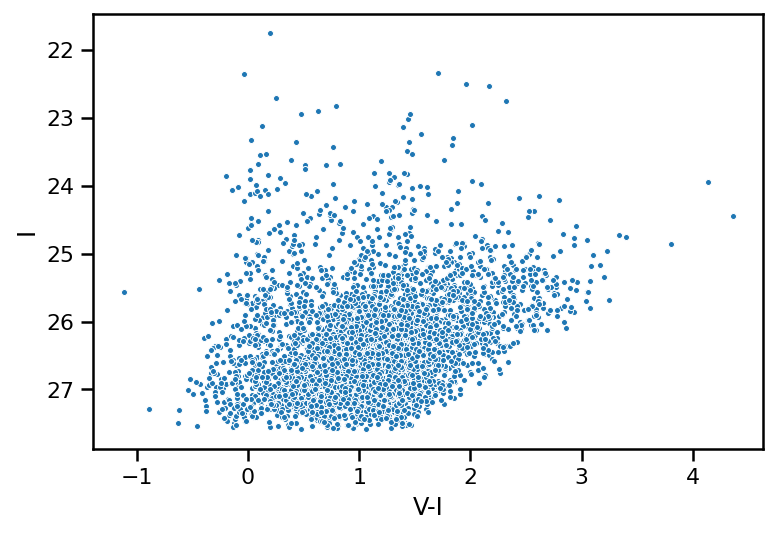

In [23]:
p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.')
yl, yh = p.axes.get_ylim()
p.axes.set_ylim(yh, yl)

(29.3687, 21.609300000000005)

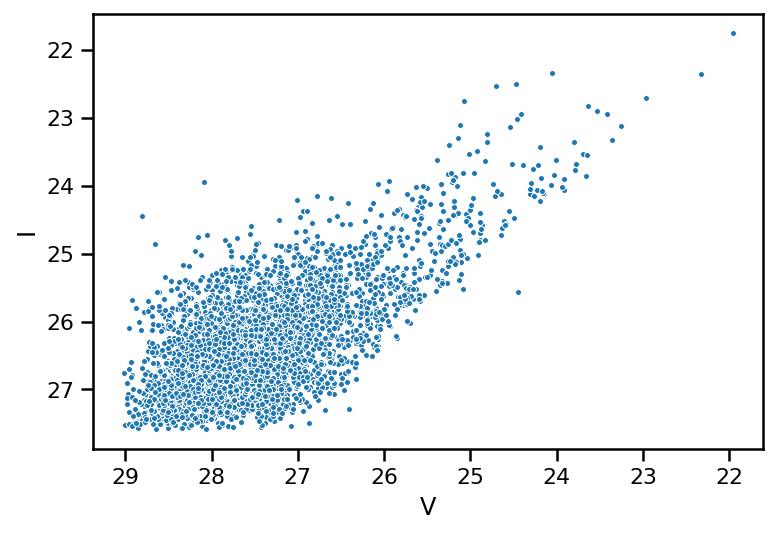

In [24]:
p = sns.scatterplot(data=data_cut, x='V', y='I', marker='.')
yl, yh = p.axes.get_ylim()
xl, xh = p.axes.get_xlim()
p.axes.set_ylim(yh, yl)
p.axes.set_xlim(xh, xl)

In [McQuinn, et al. (2017)](https://iopscience.iop.org/article/10.3847/1538-3881/aa7aad), the metallicity correction is 
$$
A_\mathrm{F814W} = -4.06 + 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right).
$$

Putting this into our language, we have 
$$
A_\mathrm{F814W} - 0.2 \left( A_\mathrm{F606W} - A_\mathrm{F814W} - 1.23 \right) = -4.06 + \mu
$$
where $\mu$ is the distance modulus.  Thus we see that $c = -0.2$, and the centering parameter for $C = 1.23$, and then $e_\mathrm{centered} = -4.06 + \mu$.

In [25]:
Aobs = np.column_stack((data_cut['I'], data_cut['V']))
sigma_obs = np.column_stack((data_cut['Ierr'], data_cut['Verr']))

c_mu = -0.2
c_sigma = 0.1
c_center = 1.23

e_center = 25.89 
e_sigma = 0.1


In [26]:
num_chains=4
thinning=1
sampler = NUTS(edge_model, dense_mass=True)
mcmc = MCMC(sampler, num_chains=num_chains, num_warmup=1000*thinning, num_samples=1000*thinning, thinning=thinning)
mcmc.run(jax_prng_key(), Aobs, sigma_obs, e_center_mu=e_center, e_center_sigma=e_sigma, c_mu=c_mu, c_sigma=c_sigma, c_center=c_center)
trace = az.from_numpyro(mcmc)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

array([[<AxesSubplot:title={'center':'e_centered'}>,
        <AxesSubplot:title={'center':'e_centered'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'mu_fg'}>,
        <AxesSubplot:title={'center':'mu_fg'}>],
       [<AxesSubplot:title={'center':'scale_fg'}>,
        <AxesSubplot:title={'center':'scale_fg'}>],
       [<AxesSubplot:title={'center':'mu_bg'}>,
        <AxesSubplot:title={'center':'mu_bg'}>],
       [<AxesSubplot:title={'center':'scale_bg'}>,
        <AxesSubplot:title={'center':'scale_bg'}>]], dtype=object)

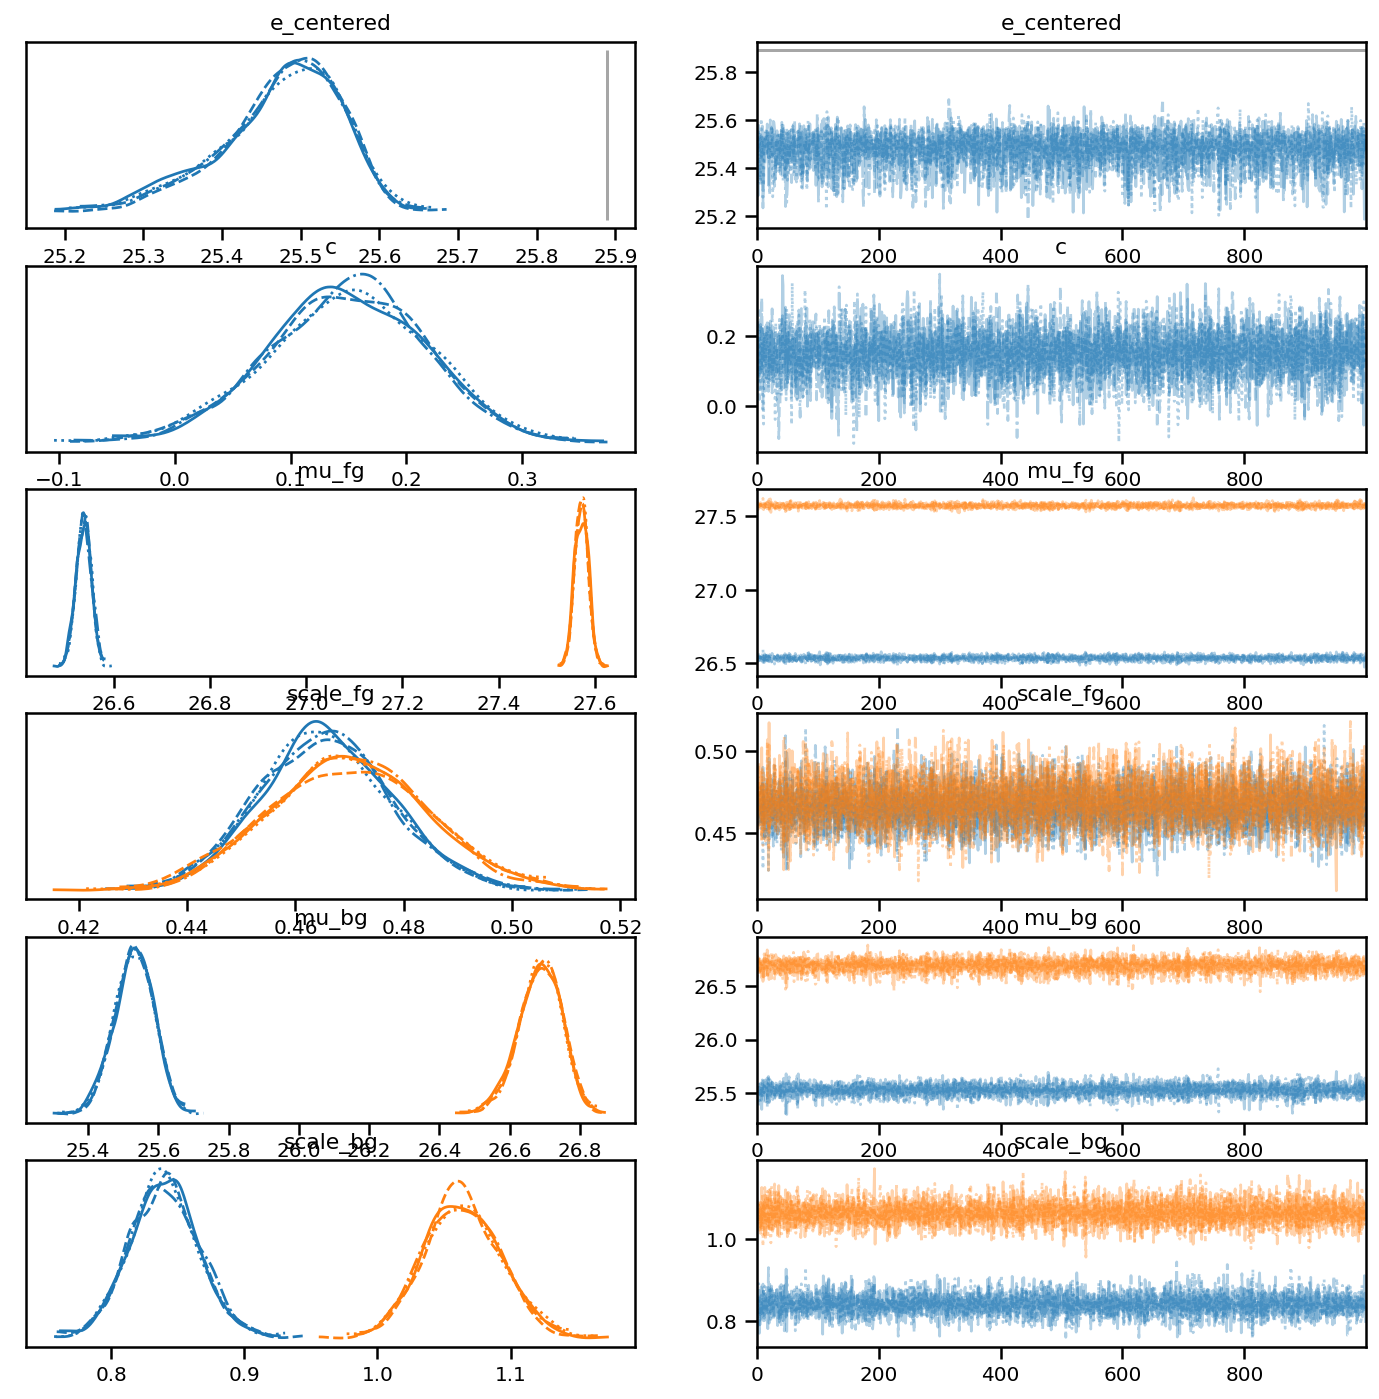

In [27]:
az.plot_trace(trace, var_names=['e_centered', 'c', 'mu_fg', 'scale_fg', 'mu_bg', 'scale_bg'],
              lines=[('e_centered', {}, e_center)])

In [28]:
az.summary(trace, var_names=['e_centered', 'c', 'mu_fg', 'mu_bg', 'cov_fg', 'cov_bg'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
e_centered,25.475,0.077,25.314,25.596,0.001,0.001,5110.0,3261.0,1.0
c[0],0.148,0.069,0.015,0.275,0.001,0.001,6037.0,3256.0,1.0
mu_fg[0],26.536,0.016,26.506,26.565,0.000,0.000,6408.0,3208.0,1.0
mu_fg[1],27.572,0.014,27.545,27.598,0.000,0.000,8468.0,3139.0,1.0
mu_bg[0],25.531,0.056,25.430,25.635,0.001,0.000,6655.0,3250.0,1.0
mu_bg[1],26.686,0.061,26.570,26.801,0.001,0.001,5862.0,2993.0,1.0
"cov_fg[0, 0]",0.217,0.011,0.196,0.239,0.000,0.000,6812.0,3337.0,1.0
"cov_fg[0, 1]",0.113,0.008,0.099,0.127,0.000,0.000,8259.0,3649.0,1.0
"cov_fg[1, 0]",0.113,0.008,0.099,0.127,0.000,0.000,8259.0,3649.0,1.0
"cov_fg[1, 1]",0.221,0.014,0.195,0.245,0.000,0.000,8599.0,3128.0,1.0


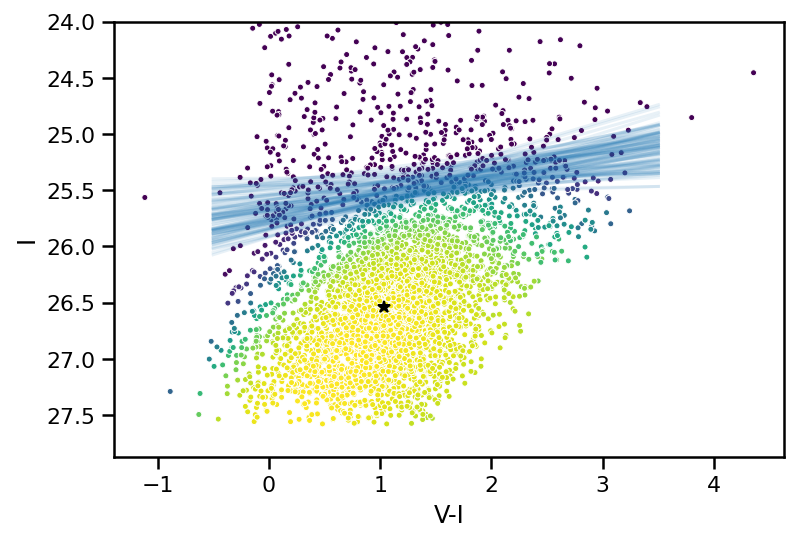

In [29]:
p = sns.scatterplot(data=data_cut, x='V-I', y='I', marker='.', c=np.exp(trace.posterior.log_fg_prob.mean(axis=(0,1))))
yl, yh = p.axes.get_ylim()
yl = 24 # Force a good-looking plot
p.axes.set_ylim(yh, yl)

vis = np.linspace(-0.5, 3.5, 1024)
for _ in range(100):
    c = np.random.choice(trace.posterior.chain)
    d = np.random.choice(trace.posterior.draw)
    plt.plot(vis, trace.posterior.e_centered[c,d].values - trace.posterior.c[c,d,0].values*(vis - c_center), color=sns.color_palette()[0], alpha=0.1)

m = trace.posterior.mu_fg
plt.plot(m[:,:,1].mean()-m[:,:,0].mean(), m[:,:,0].mean(), '*k')

array([<AxesSubplot:title={'center':'e_centered'}>,
       <AxesSubplot:title={'center':'c\n0'}>], dtype=object)

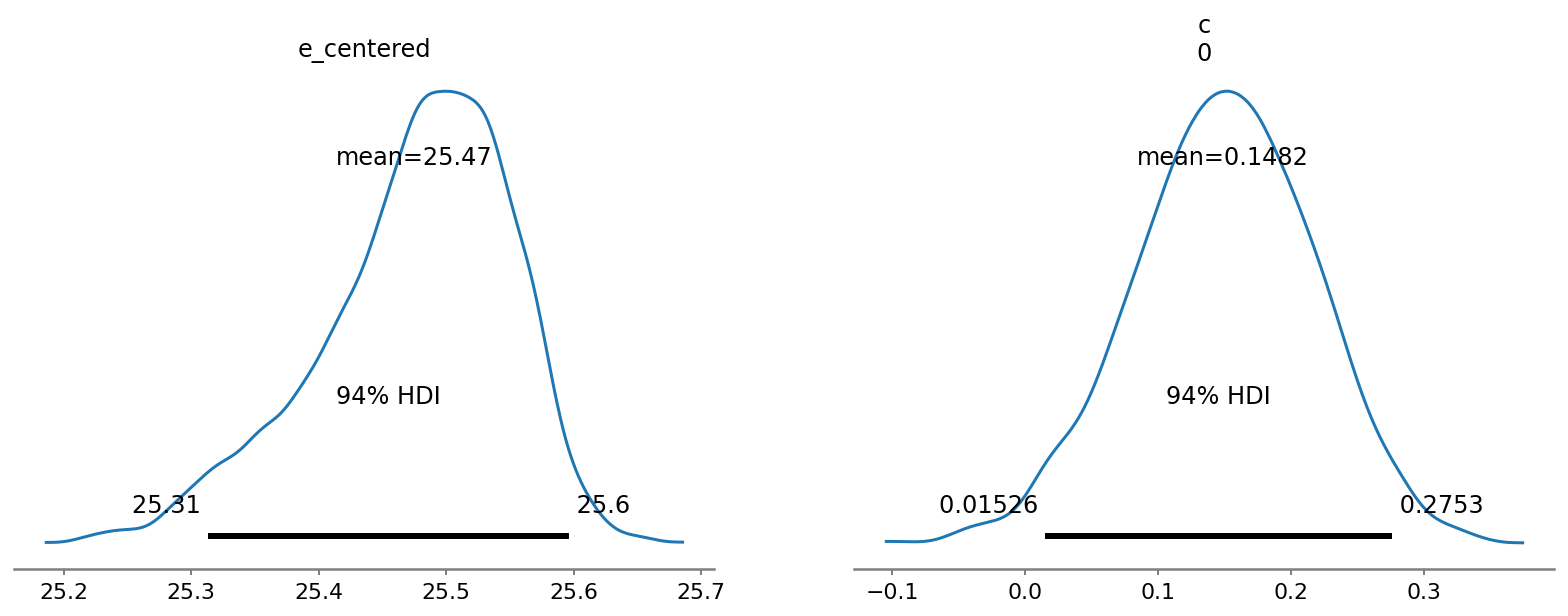

In [30]:
az.plot_posterior(trace, var_names=['e_centered', 'c'], round_to=4)